In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds
const Geo = L.Geometry

import GridWorlds
const GW = GridWorlds

using Gen
import GenPOMDPs

using GenSMCP3
# We need this to help with dualizing and undualizing values...
const DFD = GenSMCP3.GenTraceKernelDSL.DynamicForwardDiff

using VoxelRayTracers # For lineworld -> gridworld
using AStarSearch     # For gridworld path planning

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling LineWorlds [378ae85f-3ccf-4c92-8c74-de8c49c343b8]
[ Info: Precompiling GridWorlds [c15fd557-8ec5-4bf9-9d87-df57ac477796]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
[ Info: Precompiling GeometryBasicsExt [b238bd29-021f-5edc-8b0e-16b9cda5f63a]
[ Info: Precompiling GenPOMDPs [f88df91c-fa0e-46d7-b73d-4420684e5acb]
[ Info: Precompiling GenSMCP3 [6e3e2a6b-0f0c-4e92-9366-99a169bb9780]


In [2]:
(_segs, _bb, _center) = L.load_env_sparse("/Users/georgematheos/Developer/research/summer2023/tasks2d/data/environments/ambig.json")

(_segs = LineWorlds.Geometry.Segment[LineWorlds.Geometry.Segment([0.0, 0.0], [5.4, 0.0]), LineWorlds.Geometry.Segment([5.4, 0.0], [5.4, 12.0]), LineWorlds.Geometry.Segment([5.4, 12.0], [0.0, 12.0]), LineWorlds.Geometry.Segment([0.0, 12.0], [0.0, 0.0]), LineWorlds.Geometry.Segment([0.0, 0.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [4.0, 3.0]), LineWorlds.Geometry.Segment([4.0, 3.0], [4.0, 2.0]), LineWorlds.Geometry.Segment([4.0, 2.0], [0.0, 2.0]), LineWorlds.Geometry.Segment([0.0, 2.0], [0.0, 6.0])  …  LineWorlds.Geometry.Segment([4.0, 6.0], [4.0, 7.0]), LineWorlds.Geometry.Segment([4.0, 7.0], [4.0, 6.0]), LineWorlds.Geometry.Segment([4.0, 6.0], [0.0, 6.0]), LineWorlds.Geometry.Segment([0.0, 6.0], [0.0, 10.0]), LineWorlds.Geometry.Segment([0.0, 10.0], [4.0, 10.0]), LineWorlds.Geometry.Segment([4.0, 10.0], [4.0, 8.0]), LineWorlds.Geometry.Segment([4.0, 8.0], [4.0, 10.0]), LineWorlds.Geometry.Segment([4.0, 10.0], [0.0, 10.

In [3]:
function line_to_grid(_segs, _bb, ϵ)
    (x1, y1), (x2, y2) = _bb
    edges = ((x1 - ϵ):ϵ:(x2 + ϵ), (y1 - ϵ):ϵ:(y2 + ϵ))

    grid = [false for _ in edges[1], _ in edges[2]]
    for seg in _segs
        if Geo.diff(seg) ≈ [0, 0]
            continue
        end
        ray = (position=seg.x, velocity=Geo.diff(seg))
        for hit in eachtraversal(ray, edges)
                                    # TODO: is this a hack or no?
            if hit.exit_time ≤ 1. #|| (hit.entry_time == 1.0 && (ray.velocity[1] > 0 || ray.velocity[2] > 0))
                grid[hit.voxelindex] = true
            end
        end
    end

    linecoords_to_gridcoords(x, y) = (
        Int(round((x - edges[1][1] + ϵ) / ϵ)),
        Int(round((y - edges[2][1] + ϵ) / ϵ))
    )
    gridcoords_to_linecoords(x, y) = (
        edges[1][x],
        edges[2][y]
    )

    return grid, edges, linecoords_to_gridcoords, gridcoords_to_linecoords
end

line_to_grid (generic function with 1 method)

In [4]:
ϵ = 0.25
(grid, edges, l_to_g, g_to_l) = line_to_grid(_segs, _bb, ϵ)
w = GridWorlds.boolmatrix_to_grid(grid, (length(edges[1]), length(edges[2])));

GridWorlds.FGridWorld(FunctionalCollections.PersistentVector{GridWorlds.GridCell}[[GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty  …  GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall  …  GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.wall, GridWorlds.empty], [GridWorlds.empty, GridWorlds.wall, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.empty, GridWorlds.wall  …  GridWorlds.wall, GridWor

In [43]:
taxi_dist((x, y), (x2, y2)) = abs(x - x2) + abs(y - y2)
function find_action_using_grid(start_linecoords, goal_linecoords)
    actions = (:up, :down, :left, :right, :stay)
    initialpos = l_to_g(start_linecoords...)
    goalpos    = l_to_g(goal_linecoords...)

    results = astar(
        # state to neighbors
        pos -> unique(GW.newpos(w, pos, dir) for dir in actions),
        initialpos, # Initial world state
        goalpos; # Goal world state
        heuristic = ((pos, goal) -> taxi_dist(pos, goal)),
        isgoal = ((pos, goal) -> pos == goal),
        timeout = 10.
    )

    length(results.path) == 1 & return (:stay, results.path)
    
    next_state = results.path[2]
    # println("next_state: ", g_to_l(next_state...))
    action = actions[findfirst(GW.newpos(w, initialpos, dir) == next_state for dir in actions)]

    return (action, results.path)
end

find_action_using_grid (generic function with 1 method)

In [6]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.02
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.02,
            outlier      = 0.0001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [7]:
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

### Motion model ###
# The next position, under a 0-noise model, with no walls.
function det_next_pos(pos, a, Δ)
    (x, y) = DFD.value(pos)
    a == :up    ? [x, y + Δ] :
    a == :down  ? [x, y - Δ] : 
    a == :left  ? [x - Δ, y] :
    a == :right ? [x + Δ, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(DFD.value(prev), DFD.value(new))
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end
@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action, PARAMS.step.Δ)
    pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, pos, PARAMS.map)
    
    return next_pos
end

### Observation model ###
@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    # segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = L.cast([p], params.map; num_a=params.obs.n_rays, zmax)
    @assert !any(isinf.(zs))
    # zs = reshape(dists, (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w; fill_val_z=zmax)[1,:,:,:]
    @assert !any(isinf.(ỹ))

    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  

    if any(any(isinf.(o)) for o in obs)
        @warn "got an inf obs ỹ = $ỹ"
    end
    
    return obs
end;

# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

@load_generated_functions()

In [8]:
T(tr) = get_args(tr)[1]
currentpos(tr) = tr[state_addr(T(tr), :pos)]

currentpos (generic function with 1 method)

In [9]:
includet("05_inference.jl")

In [10]:
function get_actobs_seq(groundtruth_trace)
    return map(
        trace -> (
            GenPOMDPs.observation_sequence(trace),
            GenPOMDPs.action_sequence(trace)
        ),
        groundtruth_trace
    )
end

get_actobs_seq (generic function with 1 method)

In [11]:
_grid_args = (;
    tau = 1., # "temperature" for grid proposal
    pmin = 1e-6,
    init_grid_args = (;
        k = [9, 9],    # number of grid cells along each dimension
        r = [PARAMS.step.Δ/3, PARAMS.step.Δ/3] # size of grid cells at first iteration
    ),
    n_iters = 3 # number of iterations of grid proposals
)

_t0_grid_args = (;
    _grid_args...,
    tau=20,
    n_iters=5, # more iterations for the initial step

    # TODO: set this up to automatically look at the bounding box
    init_grid_args = (; k=[7, 13], r=[.8, .8]),
    initial_pos = [2.7, 6.] # center of grid for first timestep
)

PARAMS_NOISYSTEP = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (;
        Δ = 0.25,
        σ = 0.2
    ),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.1,
            outlier      = 0.001,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

pf = @get_pf(PARAMS_NOISYSTEP, _grid_args, _t0_grid_args);

In [12]:
state_addr = GenPOMDPs.state_addr

state_addr (generic function with 2 methods)

In [14]:
cnt = 0
for _=1:20
    tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
    pf_observable = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr));
    state = pf_observable[][1]
    pts = []
    for tr in GPF.get_traces(state)
        if isempty(pts)
            push!(pts, currentpos(tr))
        else
            is_replicate = false
            for pt in pts
                if Geo.norm(currentpos(tr) - pt) < 0.5
                    is_replicate = true
                    continue
                end
            end
            if !is_replicate
                push!(pts, currentpos(tr))
            end
        end
    end
    if length(pts) == 1
        cnt += 1
    end
end
cnt

UndefVarError: UndefVarError: `state_addr` not defined

In [16]:
tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
pf_observable = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr));
state = pf_observable[][1]
pts = []
for tr in GPF.get_traces(state)
    if isempty(pts)
        push!(pts, currentpos(tr))
    else
        is_replicate = false
        for pt in pts
            if Geo.norm(currentpos(tr) - pt) < 0.5
                is_replicate = true
                continue
            end
        end
        if !is_replicate
            push!(pts, currentpos(tr))
        end
    end
end

UndefVarError: UndefVarError: `state_addr` not defined

In [17]:
pts

UndefVarError: UndefVarError: `pts` not defined

In [19]:
tr, take_action = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
pf_observable = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr));

┌ Info: Saved animation to /var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_Xez0p8rKtM.gif
└ @ Plots /Users/georgematheos/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/var/folders/df/n4tcxhf52k7_k2161q4gj5ww0000gn/T/jl_Xez0p8rKtM.gif")
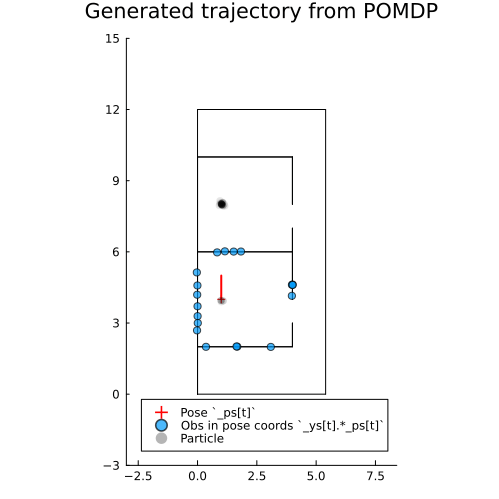

In [20]:
using Random
let tr = tr[], states = pf_observable[]

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=0:0
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
            xlim=(_bb[1][1]-3, _bb[2][1]+3),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
        plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([p.x], c=:red, marker=:cross, label="Pose `_ps[t]`")
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    
        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=max(sqrt(w), 0.1), label="Particle")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=max(sqrt(w), 0.1), label=nothing)
            end
        end
    
        frame(ani, agent_plt)
    end
    # gif(ani, "smcp3_coarse_to_fine.gif", fps=1) # gif(ani, fname, fps=10)
    gif(ani, fps=1)
end

In [22]:
GOAL = [1., 12.]

2-element Vector{Float64}:
  1.0
 12.0

In [23]:
while Geo.norm(currentpos(tr[]) - GOAL) > .3 && T(tr[]) < 50
    _tr = GPF.sample_unweighted_traces(pf_observable[][end], 1)[1]
    pos = _tr[state_addr(T(_tr), :pos)]
    action = find_action_using_grid(pos, GOAL)[1]
    take_action(action)
end

Resampling!


In [24]:
T(tr[])

50

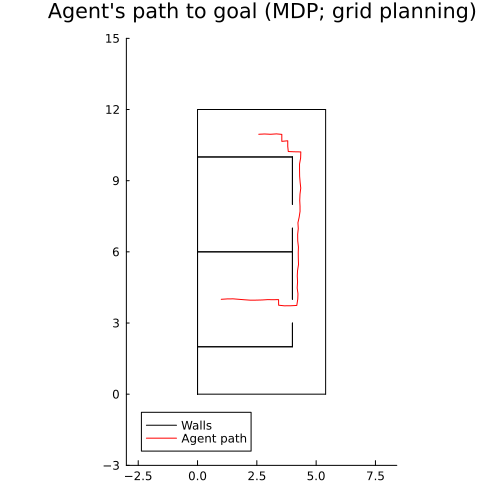

In [25]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Agent's path to goal (MDP; grid planning)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, label="Walls")
plot!(GenPOMDPs.state_sequence(tr[]), c=:red, label="Agent path")

┌ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/pomdp_nav_unambiguous.gif
└ @ Plots /Users/georgematheos/.julia/packages/Plots/9Q9pN/src/animation.jl:156


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/pomdp_nav_unambiguous.gif")
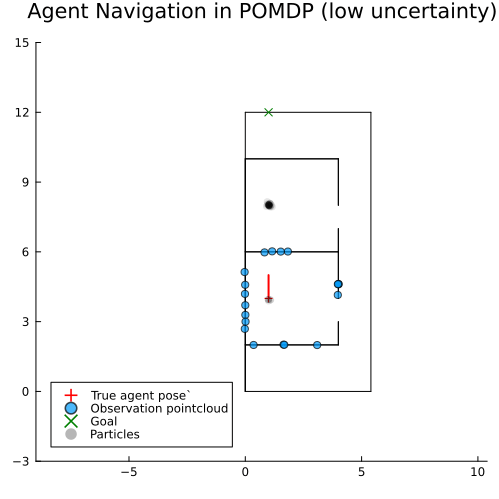

In [26]:
using Random
let tr = tr[], states = pf_observable[]

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=0:length(states)-2
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Agent Navigation in POMDP (irrelevant uncertainty)", grid=false,
            xlim=(_bb[1][1]-9, _bb[2][1]+5),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
        plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([p.x], c=:red, marker=:cross, label="True agent pose`")
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Observation pointcloud")
    
        scatter!([GOAL], c=:green, marker=:x, label="Goal")

        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label="Particles")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label=nothing)
            end
        end
    
        frame(ani, agent_plt)
    end
    gif(ani, "pomdp_nav_unambiguous.gif", fps=2) # gif(ani, fname, fps=10)
    # gif(ani, fps=10)
end

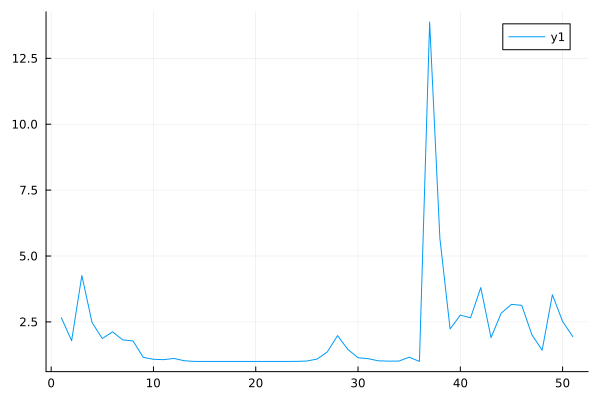

In [27]:
states = pf_observable[]
plot(GPF.get_ess.(states))

In [28]:
GPF.get_ess(states[10])

1.0813845728046447

In [44]:
tr2, take_action2 = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
pf_observable2 = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr2));

In [45]:
GOAL2 = [2., 8.] # In one of the identical rooms

2-element Vector{Float64}:
 2.0
 8.0

In [46]:
while Geo.norm(currentpos(tr2[]) - GOAL2) > .3 && T(tr2[]) < 20
    _tr = GPF.sample_unweighted_traces(pf_observable2[][end], 1)[1]
    pos = _tr[state_addr(T(_tr), :pos)]
    action = find_action_using_grid(pos, GOAL2)[1]
    take_action2(action)
end

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9942857680993136 -1.9942857680993133 -1.9942857680993131 -1.9942857680993133 -1.994285768099313 -1.9942857680993133; 100.0 100.0 100.0 100.0 -1.9942857680993136 -1.9942857680993133 -1.9942857680993131 -1.9942857680993133 -1.994285768099313 -1.9942857680993133 -1.9942857680993136; 100.0 100.0 100.0 -1.9942857680993136 -1.9942857680993133 -1.9942857680993131 -1.9942857680993133 -1.994285768099313 -1.9942857680993133 -1.9942857680993136 -1.4446444864541694; 100.0 100.0 -1.9942857680993136 -1.9942857680993133 -1.9942857680993131 -1.9942857680993133 -1.994285768099313 -1.9942857680993133 -1.9942857680993136 -1.4446444864541694 -1.2873720068273249; 100.0 -1.9942857680993136 -1.9942857680993133 -1.9942857680993131 -1.9942857680993133 -1.994285768099313 -1.9942857680993133 -1.9942857680993136 -1.4446444864541694 -1.2873720068273249 -0.5396628894793055; -1.9942857680993136 -1.9942857680993133 -1.9942857680993131 -1.994285768099313

LoadError: DomainError with [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]:
Categorical: vector p is not a probability vector

In [47]:
T(tr2[])

14

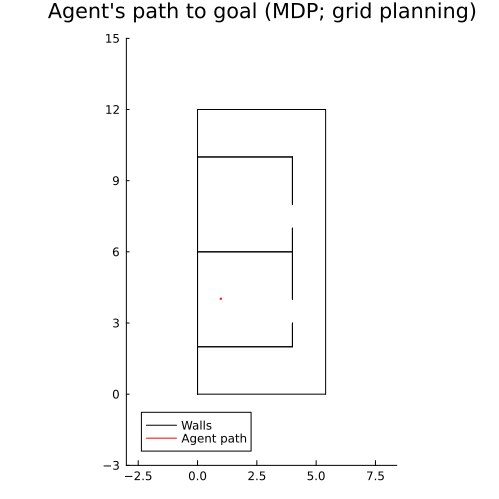

In [48]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Agent's path to goal (MDP; grid planning)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, label="Walls")
plot!(GenPOMDPs.state_sequence(tr2[]), c=:red, label="Agent path")

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/pomdp_nav_unambiguous.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/pomdp_nav_unambiguous.gif")
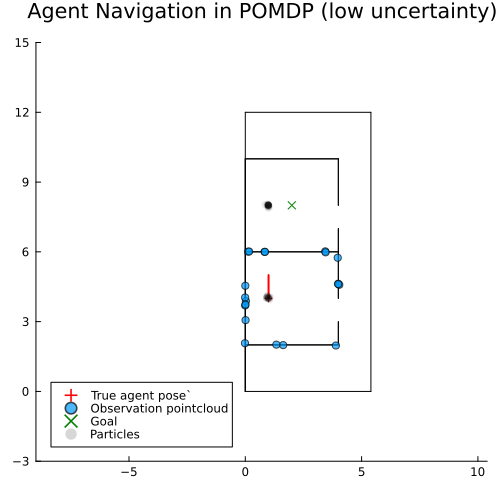

In [68]:
using Random
let tr = tr2[], states = pf_observable2[]

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=0:length(states)-2
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Agent Navigation in POMDP (low uncertainty)", grid=false,
            xlim=(_bb[1][1]-9, _bb[2][1]+5),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
        plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([p.x], c=:red, marker=:cross, label="True agent pose`")
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Observation pointcloud")
    
        scatter!([GOAL2], c=:green, marker=:x, label="Goal")

        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label="Particles")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label=nothing)
            end
        end
    
        frame(ani, agent_plt)
    end
    gif(ani, "pomdp_nav_unambiguous.gif", fps=2) # gif(ani, fname, fps=10)
    # gif(ani, fps=10)
end

In [50]:
GPF.get_norm_weights(pf_observable2[][4])

20-element Vector{Float64}:
 0.002316539485551044
 4.936664982255579e-7
 0.0003028842744196252
 0.0002635555495925908
 0.0013315484435984855
 0.0008781087153474922
 1.1549356819001916e-9
 0.0011899569596112009
 5.7411269039199196e-8
 0.0010822324382955234
 5.82572121087839e-13
 8.217123509298436e-7
 0.007748786866382529
 0.34186264993562415
 6.875675454367849e-8
 0.007962069255948279
 7.734573005905883e-9
 0.6312713982301362
 0.00378881940291449
 5.614449232576417e-12

In [186]:
"""
st  - finite state machine state (direction of wall we're following)
nbs - neighbors of the agent on grid which are filled (set of dirs)
returns (action, next_st)

dirs = [:L, :R, :U, :D]
"""
function wall_follow(st, nbs)
    isnothing(st) && :L ∉ nbs ? (:L, st) :
    isnothing(st) && :L ∈ nbs ? (:D, :L) :
    #
    st == :L && :L ∉ nbs ? (:L, :U) :
    st == :L && :D ∉ nbs ? (:D, :L) :
    st == :L && :R ∉ nbs ? (:R, :D) :
    st == :L             ? (:U, :R) :
    #
    st == :R && :R ∉ nbs ? (:R, :D) :
    st == :R && :U ∉ nbs ? (:U, :R) :
    st == :R && :L ∉ nbs ? (:L, :U) :
    st == :R             ? (:D, :L) :
    #
    st == :D && :D ∉ nbs ? (:D, :L) :
    st == :D && :R ∉ nbs ? (:R, :D) :
    st == :D && :U ∉ nbs ? (:U, :R) :
    st == :D             ? (:L, :U) :
    #
    st == :U && :U ∉ nbs ? (:U, :R) :
    st == :U && :L ∉ nbs ? (:L, :U) :
    st == :U && :D ∉ nbs ? (:D, :L) :
    st == :U             ? (:R, :D) :
    
    error("Unrecognized st/nbs pair.")
end

wall_follow

In [187]:
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(DFD.value(prev), DFD.value(new))
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end

function wallfollow_action_using_grid(pos, st)
#     pos = l_to_g(pos...)
    
    (x, y) = pos
    nbs = Set()
    
    δ = 1.25*ϵ
    for (a, newpos) in (
        (:U, [x, y + δ]), (:D, [x, y - δ]), (:L, [x - δ, y]), (:R, [x + δ, y])
    )
        if handle_wall_intersection([x, y], newpos, PARAMS.map) != newpos
            push!(nbs, a)
        end
    end
    
#     w[x + 1, y] == GW.wall && push!(nbs, :R)
#     w[x - 1, y] == GW.wall && push!(nbs, :L)
#     w[x, y + 1] == GW.wall && push!(nbs, :U)
#     w[x, y - 1] == GW.wall && push!(nbs, :D)
    
    (a, st) = wall_follow(st, nbs)
    
    act = (;U=:up,L=:left,D=:down,R=:right)[a]
    
    return (act, st)
end

wallfollow_action_using_grid (generic function with 1 method)

In [191]:
tr3, take_action3 = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
# pf_observable3 = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr3));

In [192]:
sts = Any[nothing]
while T(tr3[]) < 500
#     _tr = GPF.sample_unweighted_traces(pf_observable3[][end], 1)[1]
    pos = tr3[][state_addr(T(tr3[]))] #_tr[state_addr(T(_tr), :pos)]
    
    (a, st) = wallfollow_action_using_grid(pos, sts[end])
    println("$(T(tr3[])) : $st")
    
    push!(sts, st)
    
    # Prevent cycles
    if length(sts)>8 && sts[end-3:end] == sts[end-7:end-4] && length(Set(sts[end-3:end])) == 4
        sts[end] = nothing
    end
    
    take_action3(a)
end

0 : nothing
1 : nothing
2 : nothing
3 : L
4 : L
5 : L
6 : L
7 : L
8 : L
9 : L
10 : D
11 : D
12 : D
13 : D
14 : D


┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.0355589432081667 -1.0355589432081667 -1.0355589432081664 -1.0355589432081664 -1.0355589432081662 -1.0355589432081667; 100.0 100.0 100.0 100.0 -1.0355589432081667 -1.0355589432081667 -1.0355589432081664 -1.0355589432081664 -1.0355589432081662 -1.0355589432081667 -1.0355589432081667; 100.0 100.0 100.0 -1.0355589432081667 -1.0355589432081667 -1.0355589432081664 -1.0355589432081664 -1.0355589432081662 -1.0355589432081667 -1.0355589432081667 -1.0355589432081673; 100.0 100.0 -1.0355589432081667 -1.0355589432081667 -1.0355589432081664 -1.0355589432081664 -1.0355589432081662 -1.0355589432081667 -1.0355589432081667 -1.0355589432081673 -0.687201697228432; 100.0 -1.0355589432081667 -1.0355589432081667 -1.0355589432081664 -1.0355589432081664 -1.0355589432081662 -1.0355589432081667 -1.0355589432081667 -1.0355589432081673 -0.687201697228432 -0.28807310677458403; -1.0355589432081667 -1.0355589432081667 -1.0355589432081664 -1.03555894320

15 : D
16 : D
17 : D
18 : D
19 : D
20 : D
21 : D
22 : D
23 : D
24 : R
25 : R
26 : R
27 : R
28 : D
29 : L
30 : U
31 : R
32 : D
33 : L
34 : U
35 : nothing
36 : nothing
37 : nothing
38 : nothing
39 : nothing
40 : nothing
41 : nothing
42 : nothing
43 : nothing
44 : nothing
45 : nothing
46 : nothing
47 : nothing
48 : L
49 : U
50 : R
51 : D
52 : L
53 : L
54 : L
55 : L
56 : D
57 : D
58 : D
59 : D
60 : D
61 : D
62 : D
63 : D
64 : D
65 : D
66 : D
67 : D
68 : D
69 : D
70 : R
71 : R
72 : R
73 : D
74 : L
75 : L
76 : L
77 : L
78 : L
79 : U
80 : U
81 : U
82 : U
83 : U
84 : U
85 : U
86 : U
87 : U
88 : U
89 : U
90 : U
91 : U
92 : U
93 : U
94 : L
95 : L
96 : L
97 : L
98 : L
99 : L
100 : D
101 : D
102 : D
103 : D
104 : D
105 : D
106 : D
107 : D
108 : D
109 : D
110 : D
111 : D
112 : D
113 : D
114 : D
115 : D
116 : D
117 : D
118 : D
119 : D
120 : R
121 : R
122 : R
123 : R
124 : R
125 : R
126 : R
127 : R
128 : R
129 : R
130 : R
131 : R
132 : R
133 : R
134 : R
135 : R
136 : R
137 : R
138 : R
139 : R
140 : R

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -0.5971994179520694 -0.5971994179520694 -0.5971994179520693 -0.5971994179520693 -0.5971994179520692 -0.5971994179520693; 100.0 100.0 100.0 100.0 -0.5971994179520694 -0.5971994179520694 -0.5971994179520693 -0.5971994179520693 -0.5971994179520692 -0.5971994179520693 -0.5971994179520695; 100.0 100.0 100.0 -0.5971994179520694 -0.5971994179520694 -0.5971994179520693 -0.5971994179520693 -0.5971994179520692 -0.5971994179520693 -0.5971994179520695 -0.5971994179520699; 100.0 100.0 -0.5971994179520694 -0.5971994179520694 -0.5971994179520693 -0.5971994179520693 -0.5971994179520692 -0.5971994179520693 -0.5971994179520695 -0.5971994179520699 -0.5971994179520693; 100.0 -0.5971994179520694 -0.5971994179520694 -0.5971994179520693 -0.5971994179520693 -0.5971994179520692 -0.5971994179520693 -0.5971994179520695 -0.5971994179520699 -0.5971994179520693 -0.597199417952068; -0.5971994179520694 -0.5971994179520694 -0.5971994179520693 -0.59719941795

334 : D
335 : D
336 : D
337 : D
338 : D
339 : D
340 : D
341 : D
342 : D
343 : D
344 : D
345 : D
346 : D
347 : D
348 : R
349 : R
350 : R
351 : D
352 : L
353 : L
354 : L
355 : L
356 : L
357 : U
358 : U
359 : U
360 : U
361 : U
362 : U
363 : U
364 : U
365 : U
366 : U
367 : U
368 : U
369 : U
370 : U
371 : R
372 : D
373 : L
374 : U
375 : R
376 : D
377 : L
378 : nothing
379 : nothing
380 : nothing
381 : L
382 : L
383 : L
384 : L
385 : L
386 : L
387 : D
388 : D
389 : D
390 : D
391 : D
392 : D
393 : D
394 : D
395 : D
396 : D
397 : D
398 : D
399 : D
400 : D
401 : D
402 : D
403 : D
404 : D
405 : D
406 : D
407 : D
408 : R
409 : R
410 : R
411 : R
412 : R
413 : R
414 : R
415 : R
416 : R
417 : R
418 : R
419 : R
420 : R
421 : R
422 : R
423 : R
424 : R
425 : R
426 : R
427 : R
428 : R
429 : D
430 : L
431 : U
432 : R
433 : D
434 : L
435 : U
436 : nothing
437 : nothing
438 : nothing
439 : L
440 : U
441 : R
442 : D
443 : L
444 : U
445 : R
446 : D
447 : nothing
448 : L
449 : L
450 : L
451 : L
452 : L
453 : 

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/wall_following_test.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/wall_following_test.gif")
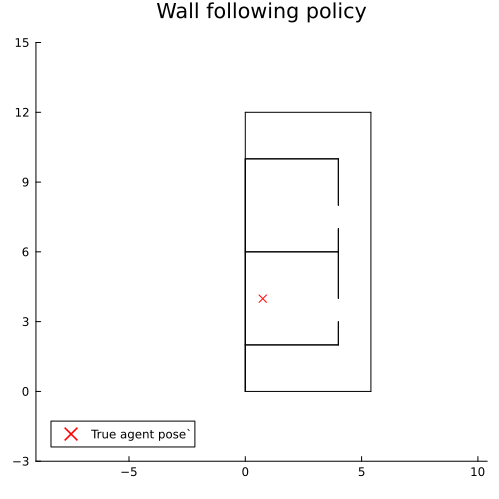

In [193]:
using Random
let tr = tr3[], states = pf_observable3[]

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=1:T(tr3[])-1
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Wall following policy", grid=false,
            xlim=(_bb[1][1]-9, _bb[2][1]+5),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
#         plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
#         scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Observation pointcloud")
    
#         scatter!([GOAL2], c=:green, marker=:x, label="Goal")

#         particles = states[t + 1]
#         labeled=false
#         for (w, tr) in zip(
#                 GenParticleFilters.get_norm_weights(particles),
#                 GenParticleFilters.get_traces(particles)
#             )
#             pos = tr[GenPOMDPs.state_addr(t)]
#             if !labeled && sqrt(w) > 0.1
#                 scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label="Particles")
#                 labeled=true
#             else
#                 scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label=nothing)
#             end
#         end
        
#         for (i, isfull) in pairs(grid)
#             (x, y) = Tuple(i)
#             (x, y) = g_to_l(x, y)
#             if isfull
#                  rect = rectangle(ϵ, ϵ, x, y)
#                  plot!(rect, opacity=.5, c=:black, label=nothing)
#             end
#         end
        
        scatter!([p.x], c=:red, marker=:x, label="True agent pose`")
        
#         plot!([0, 0], [-2, 12])
    
        frame(ani, agent_plt)
    end
    gif(ani, "wall_following_test.gif", fps=10) # gif(ani, fname, fps=10)
#     gif(ani, fps=10)
end

In [148]:
pos = tr3[][state_addr(26)]
(x, y) = l_to_g(pos...)

nbs = Set()
w[x + 1, y] == GW.wall && push!(nbs, :R)
w[x - 1, y] == GW.wall && push!(nbs, :L)
w[x, y + 1] == GW.wall && push!(nbs, :U)
w[x, y - 1] == GW.wall && push!(nbs, :D)

false

In [149]:
nbs

Set{Any} with 1 element:
  :R

In [146]:
w[18, 13]

wall::GridCell = 1

In [135]:
w[18, 13]

wall::GridCell = 1

In [119]:
g_to_l(1, 1)

(-0.25, -0.25)

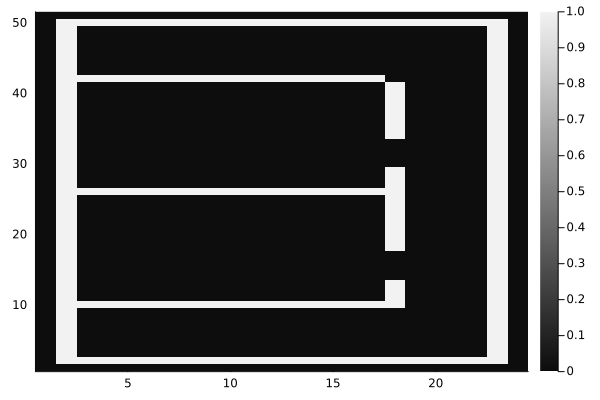

In [104]:
heatmap(transpose(grid), c=:grays)

(1, 1, false)
(2, 1, false)
(3, 1, false)
(4, 1, false)
(5, 1, false)
(6, 1, false)
(7, 1, false)
(8, 1, false)
(9, 1, false)
(10, 1, false)
(11, 1, false)
(12, 1, false)
(13, 1, false)
(14, 1, false)
(15, 1, false)
(16, 1, false)
(17, 1, false)
(18, 1, false)
(19, 1, false)
(20, 1, false)
(21, 1, false)
(22, 1, false)
(23, 1, false)
(24, 1, false)
(1, 2, false)
(2, 2, true)
(3, 2, true)
(4, 2, true)
(5, 2, true)
(6, 2, true)
(7, 2, true)
(8, 2, true)
(9, 2, true)
(10, 2, true)
(11, 2, true)
(12, 2, true)
(13, 2, true)
(14, 2, true)
(15, 2, true)
(16, 2, true)
(17, 2, true)
(18, 2, true)
(19, 2, true)
(20, 2, true)
(21, 2, true)
(22, 2, true)
(23, 2, true)
(24, 2, false)
(1, 3, false)
(2, 3, true)
(3, 3, false)
(4, 3, false)
(5, 3, false)
(6, 3, false)
(7, 3, false)
(8, 3, false)
(9, 3, false)
(10, 3, false)
(11, 3, false)
(12, 3, false)
(13, 3, false)
(14, 3, false)
(15, 3, false)
(16, 3, false)
(17, 3, false)
(18, 3, false)
(19, 3, false)
(20, 3, false)
(21, 3, false)
(22, 3, false)


(24, 23, false)
(1, 24, false)
(2, 24, true)
(3, 24, false)
(4, 24, false)
(5, 24, false)
(6, 24, false)
(7, 24, false)
(8, 24, false)
(9, 24, false)
(10, 24, false)
(11, 24, false)
(12, 24, false)
(13, 24, false)
(14, 24, false)
(15, 24, false)
(16, 24, false)
(17, 24, false)
(18, 24, true)
(19, 24, false)
(20, 24, false)
(21, 24, false)
(22, 24, false)
(23, 24, true)
(24, 24, false)
(1, 25, false)
(2, 25, true)
(3, 25, false)
(4, 25, false)
(5, 25, false)
(6, 25, false)
(7, 25, false)
(8, 25, false)
(9, 25, false)
(10, 25, false)
(11, 25, false)
(12, 25, false)
(13, 25, false)
(14, 25, false)
(15, 25, false)
(16, 25, false)
(17, 25, false)
(18, 25, true)
(19, 25, false)
(20, 25, false)
(21, 25, false)
(22, 25, false)
(23, 25, true)
(24, 25, false)
(1, 26, false)
(2, 26, true)
(3, 26, true)
(4, 26, true)
(5, 26, true)
(6, 26, true)
(7, 26, true)
(8, 26, true)
(9, 26, true)
(10, 26, true)
(11, 26, true)
(12, 26, true)
(13, 26, true)
(14, 26, true)
(15, 26, true)
(16, 26, true)
(17, 26,

(8, 46, false)
(9, 46, false)
(10, 46, false)
(11, 46, false)
(12, 46, false)
(13, 46, false)
(14, 46, false)
(15, 46, false)
(16, 46, false)
(17, 46, false)
(18, 46, false)
(19, 46, false)
(20, 46, false)
(21, 46, false)
(22, 46, false)
(23, 46, true)
(24, 46, false)
(1, 47, false)
(2, 47, true)
(3, 47, false)
(4, 47, false)
(5, 47, false)
(6, 47, false)
(7, 47, false)
(8, 47, false)
(9, 47, false)
(10, 47, false)
(11, 47, false)
(12, 47, false)
(13, 47, false)
(14, 47, false)
(15, 47, false)
(16, 47, false)
(17, 47, false)
(18, 47, false)
(19, 47, false)
(20, 47, false)
(21, 47, false)
(22, 47, false)
(23, 47, true)
(24, 47, false)
(1, 48, false)
(2, 48, true)
(3, 48, false)
(4, 48, false)
(5, 48, false)
(6, 48, false)
(7, 48, false)
(8, 48, false)
(9, 48, false)
(10, 48, false)
(11, 48, false)
(12, 48, false)
(13, 48, false)
(14, 48, false)
(15, 48, false)
(16, 48, false)
(17, 48, false)
(18, 48, false)
(19, 48, false)
(20, 48, false)
(21, 48, false)
(22, 48, false)
(23, 48, true)
(

In [198]:
tr4, take_action4 = GenPOMDPs.interactive_world_trace(trajectory_model, PARAMS, choicemap((state_addr(0, :pos), [1., 4.])));
pf_observable4 = GenPOMDPs.pf_observable(pf, get_actobs_seq(tr4));

In [199]:
sts4 = Any[nothing]
while T(tr4[]) < 60
    _tr = GPF.sample_unweighted_traces(pf_observable4[][end], 1)[1]
    pos = _tr[state_addr(T(_tr), :pos)]
    
    (a, st) = wallfollow_action_using_grid(pos, sts4[end])
    println("$(T(tr4[])) : $st")
    
    push!(sts4, st)
    
    # Prevent cycles
    if length(sts4)>8 && sts4[end-3:end] == sts4[end-7:end-4] && length(Set(sts4[end-3:end])) == 4
        sts4[end] = nothing
    end
    
    take_action4(a)
end

0 : nothing
1 : nothing
2 : nothing
3 : L
4 : L
5 : L
6 : L
7 : L
8 : L
9 : U
10 : R
11 : D
12 : L
13 : L
14 : D
15 : D
16 : D
17 : D
18 : D
19 : D
20 : D
21 : D
22 : D
23 : D
24 : D
25 : D
26 : D
27 : D
28 : R
29 : R
30 : R
31 : D
32 : L
33 : U
34 : R
35 : D
36 : L
37 : L
38 : L
39 : L
40 : L
41 : L
42 : U
Resampling!
43 : U
44 : U
45 : U
46 : U
47 : U
48 : U
49 : U
50 : U
51 : U
52 : U
53 : U


┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9314991259619119 -1.9314991259619119 -1.9314991259619114 -1.9314991259619116 -1.931499125961911 -1.9314991259619114; 100.0 100.0 100.0 100.0 -1.9314991259619119 -1.9314991259619119 -1.9314991259619114 -1.9314991259619116 -1.931499125961911 -1.9314991259619114 -1.9314991259619119; 100.0 100.0 100.0 -1.9314991259619119 -1.9314991259619119 -1.9314991259619114 -1.9314991259619116 -1.931499125961911 -1.9314991259619114 -1.9314991259619119 -1.931499125961913; 100.0 100.0 -1.9314991259619119 -1.9314991259619119 -1.9314991259619114 -1.9314991259619116 -1.931499125961911 -1.9314991259619114 -1.9314991259619119 -1.931499125961913 -1.3011353548381845; 100.0 -1.9314991259619119 -1.9314991259619119 -1.9314991259619114 -1.9314991259619116 -1.931499125961911 -1.9314991259619114 -1.9314991259619119 -1.931499125961913 -1.3011353548381845 -0.5454324480195404; -1.9314991259619119 -1.9314991259619119 -1.9314991259619114 -1.9314991259619116 -

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9377338839633902 -1.9377338839633902 -1.93773388396339 -1.9377338839633897 -1.9377338839633893 -1.9377338839633897; 100.0 100.0 100.0 100.0 -1.9377338839633902 -1.9377338839633902 -1.93773388396339 -1.9377338839633897 -1.9377338839633893 -1.9377338839633897 -1.9377338839633902; 100.0 100.0 100.0 -1.9377338839633902 -1.9377338839633902 -1.93773388396339 -1.9377338839633897 -1.9377338839633893 -1.9377338839633897 -1.9377338839633902 -1.9377338839633915; 100.0 100.0 -1.9377338839633902 -1.9377338839633902 -1.93773388396339 -1.9377338839633897 -1.9377338839633893 -1.9377338839633897 -1.9377338839633902 -1.9377338839633915 -1.305278472961375; 100.0 -1.9377338839633902 -1.9377338839633902 -1.93773388396339 -1.9377338839633897 -1.9377338839633893 -1.9377338839633897 -1.9377338839633902 -1.9377338839633915 -1.305278472961375 -0.54716923201512; -1.9377338839633902 -1.9377338839633902 -1.93773388396339 -1.9377338839633897 -1.937733

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9488870930785596 -1.9488870930785596 -1.9488870930785593 -1.9488870930785593 -1.948887093078559 -1.9488870930785591; 100.0 100.0 100.0 100.0 -1.9488870930785596 -1.9488870930785596 -1.9488870930785593 -1.9488870930785593 -1.948887093078559 -1.9488870930785591 -1.9488870930785596; 100.0 100.0 100.0 -1.9488870930785596 -1.9488870930785596 -1.9488870930785593 -1.9488870930785593 -1.948887093078559 -1.9488870930785591 -1.9488870930785596 -1.948887093078561; 100.0 100.0 -1.9488870930785596 -1.9488870930785596 -1.9488870930785593 -1.9488870930785593 -1.948887093078559 -1.9488870930785591 -1.9488870930785596 -1.948887093078561 -1.306904115282397; 100.0 -1.9488870930785596 -1.9488870930785596 -1.9488870930785593 -1.9488870930785593 -1.948887093078559 -1.9488870930785591 -1.9488870930785596 -1.948887093078561 -1.306904115282397 -0.5478506969122672; -1.9488870930785596 -1.9488870930785596 -1.9488870930785593 -1.9488870930785593 -1.

54 : U


┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9432097395403793 -1.9432097395403793 -1.9432097395403791 -1.9432097395403791 -1.9432097395403785 -1.943209739540379; 100.0 100.0 100.0 100.0 -1.9432097395403793 -1.9432097395403793 -1.9432097395403791 -1.9432097395403791 -1.9432097395403785 -1.943209739540379 -1.9432097395403793; 100.0 100.0 100.0 -1.9432097395403793 -1.9432097395403793 -1.9432097395403791 -1.9432097395403791 -1.9432097395403785 -1.943209739540379 -1.9432097395403793 -1.943209739540381; 100.0 100.0 -1.9432097395403793 -1.9432097395403793 -1.9432097395403791 -1.9432097395403791 -1.9432097395403785 -1.943209739540379 -1.9432097395403793 -1.943209739540381 -1.3156920152290994; 100.0 -1.9432097395403793 -1.9432097395403793 -1.9432097395403791 -1.9432097395403791 -1.9432097395403785 -1.943209739540379 -1.9432097395403793 -1.943209739540381 -1.3156920152290994 -0.5515345609799504; -1.9432097395403793 -1.9432097395403793 -1.9432097395403791 -1.9432097395403791 -

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9219774703778607 -1.9219774703778605 -1.9219774703778605 -1.9219774703778603 -1.9219774703778596 -1.9219774703778603; 100.0 100.0 100.0 100.0 -1.9219774703778607 -1.9219774703778605 -1.9219774703778605 -1.9219774703778603 -1.9219774703778596 -1.9219774703778603 -1.9219774703778607; 100.0 100.0 100.0 -1.9219774703778607 -1.9219774703778605 -1.9219774703778605 -1.9219774703778603 -1.9219774703778596 -1.9219774703778603 -1.9219774703778607 -1.921977470377862; 100.0 100.0 -1.9219774703778607 -1.9219774703778605 -1.9219774703778605 -1.9219774703778603 -1.9219774703778596 -1.9219774703778603 -1.9219774703778607 -1.921977470377862 -1.3017858921721561; 100.0 -1.9219774703778607 -1.9219774703778605 -1.9219774703778605 -1.9219774703778603 -1.9219774703778596 -1.9219774703778603 -1.9219774703778607 -1.921977470377862 -1.3017858921721561 -0.5457051515236584; -1.9219774703778607 -1.9219774703778605 -1.9219774703778605 -1.9219774703778

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9446301576198206 -1.9446301576198206 -1.9446301576198204 -1.9446301576198204 -1.9446301576198197 -1.94463015761982; 100.0 100.0 100.0 100.0 -1.9446301576198206 -1.9446301576198206 -1.9446301576198204 -1.9446301576198204 -1.9446301576198197 -1.94463015761982 -1.9446301576198206; 100.0 100.0 100.0 -1.9446301576198206 -1.9446301576198206 -1.9446301576198204 -1.9446301576198204 -1.9446301576198197 -1.94463015761982 -1.9446301576198206 -1.944630157619822; 100.0 100.0 -1.9446301576198206 -1.9446301576198206 -1.9446301576198204 -1.9446301576198204 -1.9446301576198197 -1.94463015761982 -1.9446301576198206 -1.944630157619822 -1.3046548213162303; 100.0 -1.9446301576198206 -1.9446301576198206 -1.9446301576198204 -1.9446301576198204 -1.9446301576198197 -1.94463015761982 -1.9446301576198206 -1.944630157619822 -1.3046548213162303 -0.5469077989195872; -1.9446301576198206 -1.9446301576198206 -1.9446301576198204 -1.9446301576198204 -1.944

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.935391886514364 -1.9353918865143642 -1.935391886514364 -1.9353918865143638 -1.9353918865143631 -1.9353918865143636; 100.0 100.0 100.0 100.0 -1.935391886514364 -1.9353918865143642 -1.935391886514364 -1.9353918865143638 -1.9353918865143631 -1.9353918865143636 -1.9353918865143642; 100.0 100.0 100.0 -1.935391886514364 -1.9353918865143642 -1.935391886514364 -1.9353918865143638 -1.9353918865143631 -1.9353918865143636 -1.9353918865143642 -1.9353918865143656; 100.0 100.0 -1.935391886514364 -1.9353918865143642 -1.935391886514364 -1.9353918865143638 -1.9353918865143631 -1.9353918865143636 -1.9353918865143642 -1.9353918865143656 -1.3020495065271458; 100.0 -1.935391886514364 -1.9353918865143642 -1.935391886514364 -1.9353918865143638 -1.9353918865143631 -1.9353918865143636 -1.9353918865143642 -1.9353918865143656 -1.3020495065271458 -0.5458156579536316; -1.935391886514364 -1.9353918865143642 -1.935391886514364 -1.9353918865143638 -1.93

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9287149123628744 -1.9287149123628744 -1.928714912362874 -1.928714912362874 -1.9287149123628735 -1.9287149123628737; 100.0 100.0 100.0 100.0 -1.9287149123628744 -1.9287149123628744 -1.928714912362874 -1.928714912362874 -1.9287149123628735 -1.9287149123628737 -1.9287149123628744; 100.0 100.0 100.0 -1.9287149123628744 -1.9287149123628744 -1.928714912362874 -1.928714912362874 -1.9287149123628735 -1.9287149123628737 -1.9287149123628744 -1.9287149123628757; 100.0 100.0 -1.9287149123628744 -1.9287149123628744 -1.928714912362874 -1.928714912362874 -1.9287149123628735 -1.9287149123628737 -1.9287149123628744 -1.9287149123628757 -1.3046933399562006; 100.0 -1.9287149123628744 -1.9287149123628744 -1.928714912362874 -1.928714912362874 -1.9287149123628735 -1.9287149123628737 -1.9287149123628744 -1.9287149123628757 -1.3046933399562006 -0.5469239458300643; -1.9287149123628744 -1.9287149123628744 -1.928714912362874 -1.928714912362874 -1.92

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9175795616481495 -1.9175795616481497 -1.9175795616481495 -1.9175795616481492 -1.9175795616481488 -1.9175795616481492; 100.0 100.0 100.0 100.0 -1.9175795616481495 -1.9175795616481497 -1.9175795616481495 -1.9175795616481492 -1.9175795616481488 -1.9175795616481492 -1.9175795616481497; 100.0 100.0 100.0 -1.9175795616481495 -1.9175795616481497 -1.9175795616481495 -1.9175795616481492 -1.9175795616481488 -1.9175795616481492 -1.9175795616481497 -1.917579561648151; 100.0 100.0 -1.9175795616481495 -1.9175795616481497 -1.9175795616481495 -1.9175795616481492 -1.9175795616481488 -1.9175795616481492 -1.9175795616481497 -1.917579561648151 -1.3013503408628933; 100.0 -1.9175795616481495 -1.9175795616481497 -1.9175795616481495 -1.9175795616481492 -1.9175795616481488 -1.9175795616481492 -1.9175795616481497 -1.917579561648151 -1.3013503408628933 -0.5455225695839964; -1.9175795616481495 -1.9175795616481497 -1.9175795616481495 -1.9175795616481

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9230580305295344 -1.9230580305295346 -1.9230580305295344 -1.9230580305295344 -1.9230580305295335 -1.923058030529534; 100.0 100.0 100.0 100.0 -1.9230580305295344 -1.9230580305295346 -1.9230580305295344 -1.9230580305295344 -1.9230580305295335 -1.923058030529534 -1.9230580305295346; 100.0 100.0 100.0 -1.9230580305295344 -1.9230580305295346 -1.9230580305295344 -1.9230580305295344 -1.9230580305295335 -1.923058030529534 -1.9230580305295346 -1.9230580305295357; 100.0 100.0 -1.9230580305295344 -1.9230580305295346 -1.9230580305295344 -1.9230580305295344 -1.9230580305295335 -1.923058030529534 -1.9230580305295346 -1.9230580305295357 -1.3006155715482686; 100.0 -1.9230580305295344 -1.9230580305295346 -1.9230580305295344 -1.9230580305295344 -1.9230580305295335 -1.923058030529534 -1.9230580305295346 -1.9230580305295357 -1.3006155715482686 -0.5452145562596982; -1.9230580305295344 -1.9230580305295346 -1.9230580305295344 -1.923058030529534

┌ Warning: got an inf obs ỹ = [100.0 100.0 100.0 100.0 100.0 -1.9356679707846234 -1.9356679707846234 -1.935667970784623 -1.935667970784623 -1.9356679707846225 -1.9356679707846227; 100.0 100.0 100.0 100.0 -1.9356679707846234 -1.9356679707846234 -1.935667970784623 -1.935667970784623 -1.9356679707846225 -1.9356679707846227 -1.9356679707846234; 100.0 100.0 100.0 -1.9356679707846234 -1.9356679707846234 -1.935667970784623 -1.935667970784623 -1.9356679707846225 -1.9356679707846227 -1.9356679707846234 -1.9356679707846245; 100.0 100.0 -1.9356679707846234 -1.9356679707846234 -1.935667970784623 -1.935667970784623 -1.9356679707846225 -1.9356679707846227 -1.9356679707846234 -1.9356679707846245 -1.2998634597275984; 100.0 -1.9356679707846234 -1.9356679707846234 -1.935667970784623 -1.935667970784623 -1.9356679707846225 -1.9356679707846227 -1.9356679707846234 -1.9356679707846245 -1.2998634597275984 -0.5448992730034197; -1.9356679707846234 -1.9356679707846234 -1.935667970784623 -1.935667970784623 -1.93

55 : U
56 : U
57 : U
58 : L
59 : L


[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld_tasks/tmp.gif")
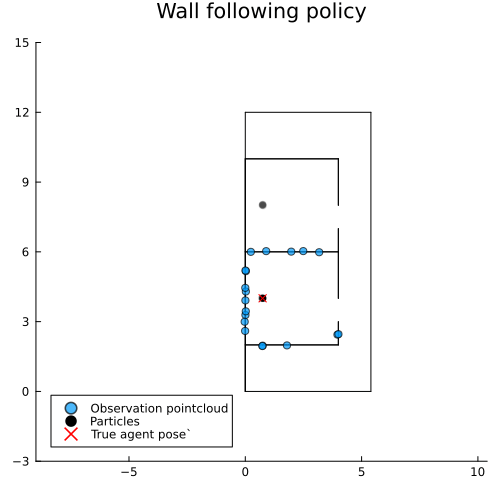

In [200]:
using Random
let tr = tr4[], states = pf_observable4[]

    poses = [
        L.Pose(position, PARAMS.orientation)
        for position in GenPOMDPs.state_sequence(tr)
    ];
    ptclouds = [
        obss[:obs].*pose
        for (obss, pose) in zip(
            GenPOMDPs.observation_sequence(tr),
            poses
        )
    ];

    # -----------------------
    col = palette(:default)
    ani = Animation()
    # states = [state]
    for t=1:T(tr4[])-1
        p = poses[t + 1]
        y = ptclouds[t + 1]
    
        agent_plt = plot(
            size=(500,500), aspect_ratio=:equal, title="Wall following policy", grid=false,
            xlim=(_bb[1][1]-9, _bb[2][1]+5),
            ylim=(_bb[1][2]-3, _bb[2][2]+3),
            legend=:bottomleft,
        )
        plot!(_segs, c=:black, linewidth=1, label=nothing)
#         plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Observation pointcloud")
    
#         scatter!([GOAL2], c=:green, marker=:x, label="Goal")

        particles = states[t + 1]
        labeled=false
        for (w, tr) in zip(
                GenParticleFilters.get_norm_weights(particles),
                GenParticleFilters.get_traces(particles)
            )
            pos = tr[GenPOMDPs.state_addr(t)]
            if !labeled && sqrt(w) > 0.1
                scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label="Particles")
                labeled=true
            else
                scatter!([pos], c=:black, seriesalpha=max(.1, sqrt(w)), label=nothing)
            end
        end
        
#         for (i, isfull) in pairs(grid)
#             (x, y) = Tuple(i)
#             (x, y) = g_to_l(x, y)
#             if isfull
#                  rect = rectangle(ϵ, ϵ, x, y)
#                  plot!(rect, opacity=.5, c=:black, label=nothing)
#             end
#         end
        
        scatter!([p.x], c=:red, marker=:x, label="True agent pose`")
        
#         plot!([0, 0], [-2, 12])
    
        frame(ani, agent_plt)
    end
    gif(ani, "wall_following_.gif", fps=10) # gif(ani, fname, fps=10)
#     gif(ani, fps=10)
end